In [1]:
using ComputationalHeatTransfer

In [2]:
# using Plots
using LaTeXStrings

In [3]:
using Revise
using LinearAlgebra
using DifferentialEquations
using Interpolations
using JLD
using Plots
pyplot()  

Plots.PyPlotBackend()

In [4]:
cd(dirname(pwd()))
cd("src") 

includet("OneDOHP.jl")
using ..OneDOHP

# the plate code initialization

### Physical parameters

In [110]:
ρ = 2702;
c = 9.03e02;
k = 2.37e02;
d = 2e-3;
params = HeatConductionParameters(ρ,c,k,thickness=d)

┌ Warning: C:\Users\liyux\.julia\packages\StructArrays\bekT9\src\refarray.jl no longer exists, deleted all methods
└ @ Revise C:\Users\liyux\.julia\packages\Revise\1boD5\src\packagedef.jl:650
┌ Warning: C:\Users\liyux\.julia\packages\StructArrays\bekT9\src\groupjoin.jl no longer exists, deleted all methods
└ @ Revise C:\Users\liyux\.julia\packages\Revise\1boD5\src\packagedef.jl:650
┌ Error: Failed to revise C:\Users\liyux\.julia\packages\StructArrays\bekT9\src\StructArrays.jl
│   exception = Revise.ReviseEvalException("C:\\Users\\liyux\\.julia\\packages\\StructArrays\\bekT9\\src\\StructArrays.jl:28", ArgumentError("Package StructArrays does not have Adapt in its dependencies:\n- If you have StructArrays checked out for development and have\n  added Adapt as a dependency but haven't updated your primary\n  environment's manifest file, try `Pkg.resolve()`.\n- Otherwise you may need to report an issue with StructArrays"), Any[(top-level scope at StructArrays.jl:28, 1)])
└ @ Revise C:\User

HeatConductionParameters(2702.0, 903.0, 237.0, 9.713488962279695e-5, 0.002)

### Geometry parameters

In [111]:
Lx = 0.1524
Ly = 0.0648;
inch = 2.54e-2;

In [112]:
xlim = (-Lx/2,Lx/2) .* 1.1
ylim = (-Ly/2,Ly/2) .* 1.1
# Δx, Δt = setstepsizes(params.α,gridPe=0.1,fourier=200.0)
Δx, Δt = setstepsizes(params.α,gridPe=8.0,fourier=0.15)
# Δx, Δt = setstepsizes(params.α,gridPe=5.0,fourier=1000000.0)

(0.0007770791169823756, 0.0009324949403788506)

### Set up the boundary of the domain

In [113]:
bdry = Rectangle(Lx/2,Ly/2,1.5Δx)

Rectangular body with 368 points and half-lengths (0.0762,0.0324)
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


### Set up the evaporator and condenser

In [114]:
eb = Rectangle(inch,inch,1.5*Δx)
Te = RigidTransform((0.0,-0.0),0.0)
Te(eb)
cb1 = Rectangle(0.5inch,inch,1.5*Δx)
Tc = RigidTransform((-2inch,-0.0),0.0)
Tc(cb1)

cb2 = Rectangle(0.5inch,inch,1.5*Δx)
Tc = RigidTransform((2inch,-0.0),0.0)
Tc(cb2)

qe = 15500.0
hc = 2000.0
Tc = -10.0

eparams = PrescribedHeatFluxRegion(qe,eb);
cparams1 = PrescribedHeatModelRegion(hc,Tc,cb1);
cparams2 = PrescribedHeatModelRegion(hc,Tc,cb2);

### Set up the OHP

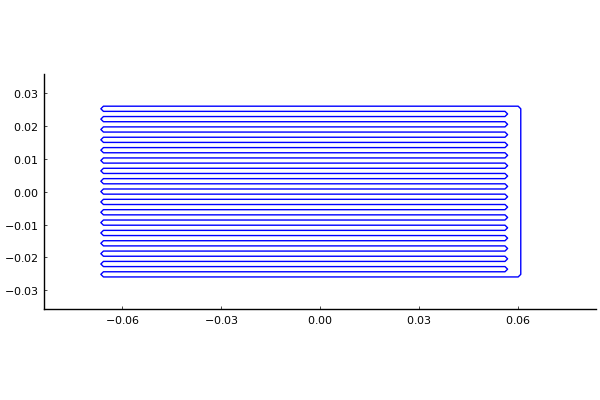

In [115]:
ds = 1.5Δx
nturn = 16
#pitch = 0.125
length_ohp = Ly*0.8
height = Lx*0.8
gap = 2*d
pitch = length_ohp/(2*nturn+1)
x0, y0 = height/2, length_ohp/2
x, y, xf, yf = ComputationalHeatTransfer.construct_ohp_curve(nturn,pitch,height,gap,ds,x0,y0,false,false,3pi/2)
ohp = BasicBody(x,y)

plot(ohp,fillalpha=0,linecolor=:blue,xlims=xlim,ylims=ylim)


In [116]:
ohpgeom = ComputationalHeatTransfer.LineSourceParams(ohp)
qtmp = zeros(numpts(ohp));

### Create the system

In [117]:
sys = HeatConduction(params,Δx,xlim,ylim,Δt,bodies=BodyList([bdry]),qline=ohpgeom,qflux=eparams,bctype=ComputationalHeatTransfer.AdiabaticBC,qmodel=[cparams1,cparams2])
#sys = HeatConduction(params,Δx,xlim,ylim,Δt,qline=ohpgeom)

Internal problem Heat conduction system on a grid of size 220 x 96 and 368 static immersed points
   1 body


#### Initialize state, and create the integrator

In [118]:
u0 = newstate(sys)
# tspan = (0.0,1.0)
tspan = (0.0,0.1)
integrator = init(u0,tspan,sys)

t: 0.0
u: (Primal nodes in a (nx = 220, ny = 96) cell grid of type Float64 data
  Number of Primal nodes: (nx = 219, ny = 95), Float64[])

### Set up values for the OHP heat flux per unit length and advance the solution

In [119]:
fill!(qtmp,-0.0)
set_linesource_strength!(sys,qtmp)

Internal problem Heat conduction system on a grid of size 220 x 96 and 368 static immersed points
   1 body


In [120]:
@time step!(integrator,0.001)
maximum(integrator.u[:])

  0.200942 seconds (7.16 k allocations: 32.339 MiB)


0.005923316766251164

In [121]:
integrator.t

0.0018649898807577012

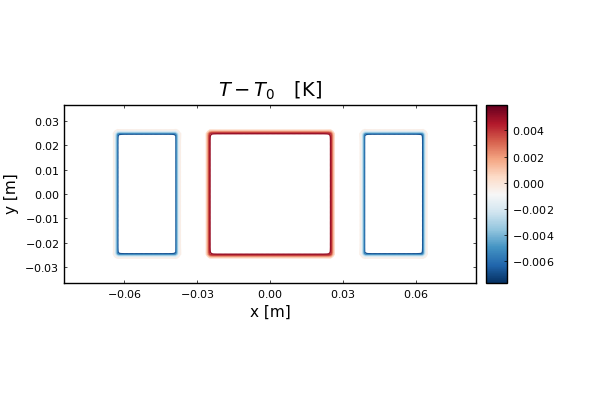

In [122]:
plot(temperature(integrator),sys.grid,legend=true,color=cgrad(:RdBu,rev=true),line_z=0,xlabel="x [m]",ylabel="y [m]",title=L"T - T_0 \quad [\mathrm{K}]")
# plot!(ohp,fillalpha=0,line_z=qtmp)

In [123]:
maximum(integrator.u[:])

0.005923316766251164

### Plot the temperature along the OHP channel

In [124]:
# plot(ohp,fillalpha=0,line_z=temperature_linesource(integrator))

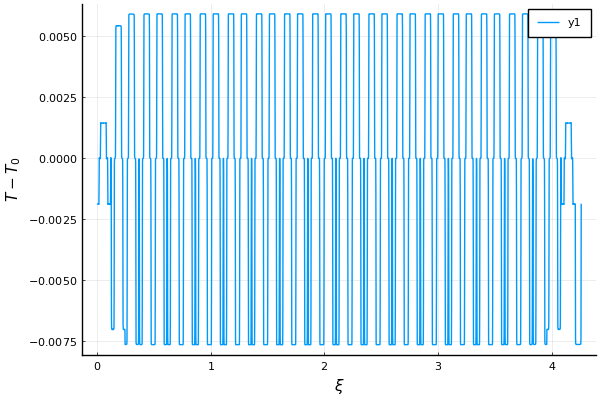

In [125]:
plot(sys.qline[1].arccoord,temperature_linesource(integrator),xlabel=L"\xi",ylabel=L"T - T_0")

# OHP inner part

In [152]:
T0 = 273.15
nondi_Q_to_Q = 8.52e01
t_to_nondi_t = 3.42e-01
function di_T_to_nondi_T(di_T;T0=273.15) 
    
    (di_T+T0)/T0
    
end

di_T_to_nondi_T (generic function with 1 method)

In [153]:
    ω = sqrt(1.68e003);
    ℘L = 6.2e004;
    k = 115e-003

    θinitial=1.0
    θc = 1.0; # useless

    Hwc = 0.0; #not useful later on. H between wall and condenser, 
    Hₗ   =  1600.0; # liquid wall heat transfer coeffcient
#     Hₗ   =  2.57e004; # liquid wall heat transfer coeffcient
    Hδ  = 7.34e002;


In [154]:
    
    d = 6.56e-3 # dimensionless diameter
    L = 35.0  # total length of the pipe when streched to a 1D pipe
    L2D = 1.0 # the actual length of the bended pipe in the real world
    angle = 0*pi/2 # inclination angle 
    closedornot = true

true

In [155]:
    nucleatenum = 32
    Xstations = sort(rand(nucleatenum).*L);
#     boilingΔt = 0.05

In [156]:
tube = Tube(d,L,L2D,angle,closedornot);

In [157]:
Xe = map(tuple, [1.0], [3.0])
We = [0.0]
evap = Evaporator(Xe,We);

In [158]:
Xc = map(tuple, [0.0,3.0], [1.0,4.0])
cond = Condenser(θc,Xc,Hwc);

In [159]:
numofX=16
Xps = sort(rand(2*numofX).*L);
Xp1s = Xps[1:2:end];
Xp2s = Xps[2:2:end];

dXdt0 = map(tuple,0*Xp1s,0*Xp2s)
X0 = map(tuple,Xp1s,Xp2s);


In [160]:
N=numpts(ohp)
# X0 = [(L/4, L*3/4)]
# dXdt0 = [(0.0,0.0)]
ρ = 214.6
Xarrays,θarrays = constructXarrays(X0,N,θinitial,L)
liquids=Liquid(Hₗ,ρ,ω,℘L,X0,dXdt0,Xarrays,θarrays);

In [161]:
# P = [1.0,1.0,1.0,1.0,1.0]; # closed end

γ = 1.4;
Hδ = 7.34e2
P = 0*Xp1s .+ 1.0;
δ = 0*Xp1s .+ 2.86e-02;
vapors=Vapor(γ,Hδ,P,δ);

In [162]:
α = 0 # nondimensional thermal diffusivity = (αₐ d^2) / (νₗ height^2)
Xwallarray,θwallarray = constructXarrays(L,N,θinitial)
θwallarray = di_T_to_nondi_T(temperature_linesource(integrator));

wall = Wall(α,Δt,Xstations,Xwallarray,θwallarray);

In [163]:
sys0_nomapping = PHPSystem_nomapping(tube,evap,cond,liquids,vapors,wall);
θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall = sys_interpolation(sys0_nomapping)
mapping = Mapping(θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall);

In [164]:
sys0 = PHPSystem(tube,evap,cond,liquids,vapors,wall,mapping);

### construct state vector U

In [165]:
Lvaporplug = XptoLvaporplug(X0,sys0.tube.L,sys0.tube.closedornot)
M = P.^(1/γ).* Lvaporplug


u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];

In [166]:
# cb_boiling =  ContinuousCallback(boiling_condition,boiling_affect!)
cb_boiling =  PeriodicCallback(boiling_affect!,0.005*t_to_nondi_t)
cb_merging =  DiscreteCallback(merging_condition,merging_affect!)

cbst = CallbackSet(cb_boiling,cb_merging);

### solve OHP (with nondimentional wall tempeature = 1.0)

In [167]:
tstep=1e-4
# tstep=5e-5*t_to_nondi_t

p = sys0
tspan = (0.0, 0.1);
prob = ODEProblem(ODE_innertube, u, tspan, p)

integrator_tube = init(deepcopy(prob), RK4(), dt=tstep, callback=cbst);

@time solve!(integrator_tube);


 11.689558 seconds (5.89 M allocations: 5.441 GiB, 35.80% gc time)


In [168]:
sol = integrator_tube.sol
sysfinal = getcurrentsys.(sol.u,[sys0]);

# combine inner tube and plate together

In [169]:
tspan = (0.0, 1.0);
dt_record = tspan[2] /100;
tstep=2e-4;

In [170]:
u0 = newstate(sys)
integrator_plate = init(u0,tspan,sys)

t: 0.0
u: (Primal nodes in a (nx = 220, ny = 96) cell grid of type Float64 data
  Number of Primal nodes: (nx = 219, ny = 95), Float64[])

In [171]:
u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];
prob = ODEProblem(ODE_innertube, u, tspan, p)
integrator_tube = init(prob, RK4(),save_everystep=false, callback=cbst)

t: 0.0
u: 2055-element Array{Float64,1}:
  1.2679473887558323
  2.456388817820482
  3.534791097570179
  4.495844599708748
  4.733053188595386
  5.7323999731227735
  6.340352520760709
  7.535502434571946
  8.552329450635108
 11.425582327809268
 11.522309364681346
 15.661107772377697
 16.92078909811449
  ⋮
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0

In [172]:
plate_hist = []
tube_hist  = []
currentsys = getcurrentsys(integrator_tube.u,sys0)
@time for t in tspan[1]:tstep:tspan[2]
    


    currentsys.wall.θarray = di_T_to_nondi_T(temperature_linesource(integrator_plate))
    currentsys = getcurrentsys(integrator_tube.u,currentsys)
    
    
    nondi_qtmp = sys_to_heatflux(currentsys)
    qtmp = nondi_Q_to_Q*nondi_qtmp
    set_linesource_strength!(sys,qtmp)
    
    
    # reinitialize the integrator_plate to avoid some mysterious problems
    integrator_plate = init(deepcopy(integrator_plate.u),(integrator_plate.t,integrator_plate.t + tstep),sys)
    step!(integrator_plate,tstep, true)
    
    
    # reinitialize the integrator_tube to avoid some mysterious problems
    prob = ODEProblem(ODE_innertube, deepcopy(integrator_tube.u), (integrator_plate.t*t_to_nondi_t-tstep*t_to_nondi_t,integrator_plate.t*t_to_nondi_t), currentsys)
    integrator_tube = deepcopy(init(prob, RK4(), dt=tstep*t_to_nondi_t, callback=cbst));
    step!(integrator_tube);

#   step!(integrator_tube, tstep*t_to_nondi_t, true)

    if (mod(integrator_plate.t,dt_record) < 1e-6) || (mod(-integrator_plate.t,dt_record) < 1e-6)
        push!(plate_hist,deepcopy(integrator_plate)); 
        push!(tube_hist,deepcopy(integrator_tube));
        println(integrator_plate.t)
    end
    
end

0.01
0.01999999999999999
0.02999999999999993
0.03999999999999987
0.04999999999999981
0.05999999999999975
0.06999999999999995
0.08000000000000024
0.09000000000000052
0.10000000000000081
0.1100000000000011
0.12000000000000138
0.13000000000000167
0.14000000000000196
0.15000000000000224
0.16000000000000253
0.17000000000000282
0.1800000000000031
0.1900000000000034
0.20000000000000367
0.21000000000000396
0.22000000000000425
0.23000000000000453
0.24000000000000482
0.2500000000000051
0.260000000000004
0.2700000000000029
0.2800000000000018
0.2900000000000007
0.2999999999999996
0.3099999999999985
0.3199999999999974
0.3299999999999963
0.3399999999999952
0.3499999999999941
0.359999999999993
0.3699999999999919
0.3799999999999908
0.3899999999999897
0.3999999999999886
0.4099999999999875
0.4199999999999864
0.4299999999999853
0.4399999999999842
0.4499999999999831
0.459999999999982
0.4699999999999809
0.4799999999999798
0.4899999999999787
0.4999999999999776
0.5099999999999765
0.5199999999999754
0.5299999

In [173]:
integrator_plate.sol

retcode: Default
Interpolation: 3rd order Hermite
t: 2-element Array{Float64,1}:
 0.9999999999999225
 1.0001999999999225
u: 2-element Array{ArrayPartition{Float64,Tuple{Nodes{Primal,220,96,Float64,Array{Float64,2}},Array{Float64,1}}},1}:
 Primal nodes in a (nx = 220, ny = 96) cell grid of type Float64 data
  Number of Primal nodes: (nx = 219, ny = 95)Float64[]
 Primal nodes in a (nx = 220, ny = 96) cell grid of type Float64 data
  Number of Primal nodes: (nx = 219, ny = 95)Float64[]

In [174]:
sysfinal = []
for i = 1:length(tube_hist)
    push!(sysfinal, deepcopy(getcurrentsys(tube_hist[i].u,tube_hist[i].p)))
end

In [175]:
# plot(ohp,fillalpha=0,line_z=temperature_linesource(integrator_plate))

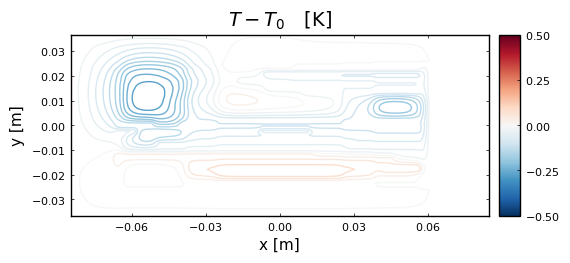

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\tmp.gif")
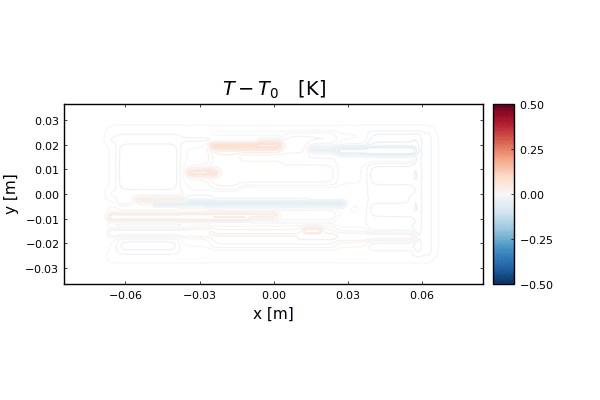

In [215]:
@gif for i = 1:1:length(plate_hist)
plot(temperature(plate_hist[i]),sys.grid,legend=true,color=cgrad(:RdBu,rev=true),line_z=0,clim=(-0.5,0.5),xlabel="x [m]",ylabel="y [m]",title=L"T - T_0 \quad [\mathrm{K}]")
# plot!(ohp,fillalpha=0,line_z=0 .* qtmp)
end

In [183]:
xc, yc = coordinates(temperature(integrator),sys.grid);

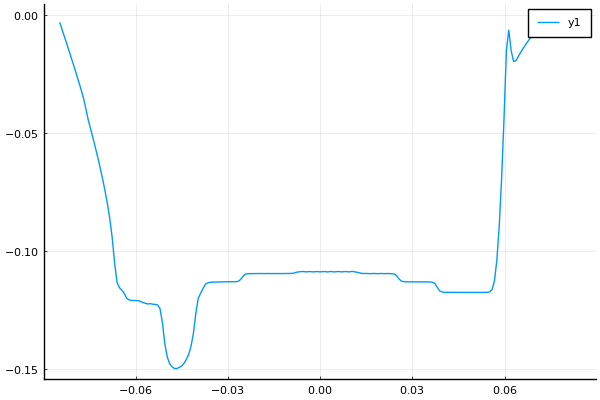

In [184]:
plot(xc,temperature(integrator_plate)[:,floor(Int,size(sys.grid,2)/2)])

# plot the OHP

┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `fillcolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning:

┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `fillcolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning:

┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `fillcolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning:

┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `fillcolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warnin

┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `fillcolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning:

┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `fillcolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warnin

┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `fillcolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning:

┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `fillcolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:3654.
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\utils.jl:108
┌ Warning:

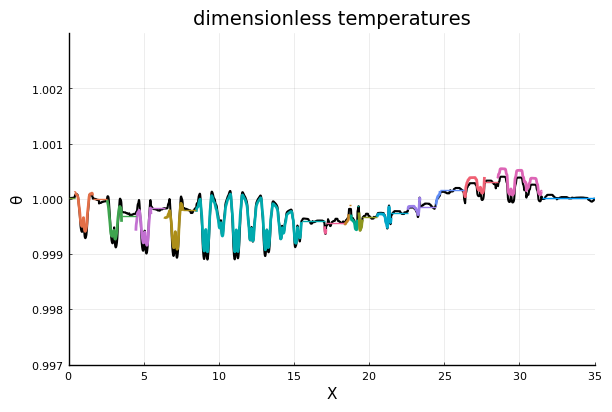

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
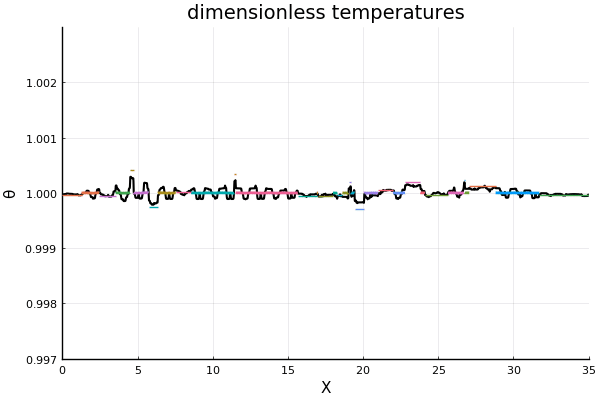

In [186]:
# closed loop plot
@gif for i=1:1:length(sysfinal)
# @gif for i=1:1:80
        
    Xpvapor = getXpvapor(sysfinal[i].liquid.Xp,sysfinal[i].tube.L,sysfinal[i].tube.closedornot)
    θvapor  = (sysfinal[i].vapor.P).^((γ-1)/γ)
    Xp = sysfinal[i].liquid.Xp
    
#     sysfinal[i].wall.θarray = di_T_to_nondi_T(temperature_linesource(plate_hist[i]))
    
    p = plot([sysfinal[i].wall.Xarray],[sysfinal[i].wall.θarray], linewidth=1.5, ylim=(0.997,1.003), color = [:black],legend=:none, labels = "θwall", xlabel="X", ylabel="θ", title=("dimensionless temperatures"),xlim=(0,sysfinal[i].tube.L))
    
    
    j=1
    while j <= length(Xp)
        if Xp[j][end] >= Xp[j][1]
            plot!(p, [sysfinal[i].liquid.Xarrays[j]],[sysfinal[i].liquid.θarrays[j]], linewidth=2, labels = string("θliquid ",j))
            else 
            # find the index at the end
            index = findfirst(x->x <= sysfinal[i].liquid.Xarrays[j][end], sysfinal[i].liquid.Xarrays[j])
            
            plot!(p, [sysfinal[i].liquid.Xarrays[j][1:index-1]],[sysfinal[i].liquid.θarrays[j][1:index-1]], linewidth=2, labels = string("θliquid ",j))
            plot!(p, [sysfinal[i].liquid.Xarrays[j][index:end]],[sysfinal[i].liquid.θarrays[j][index:end]], linewidth=2, labels = string("θliquid ",j))

        end
        
        j += 1
    end

        j=1
    while j <= length(Xpvapor)
        if Xpvapor[j][end] >= Xpvapor[j][1]
            plot!(p,[Xpvapor[j][1],Xpvapor[j][end]],[θvapor[j]], labels = string("θvapor ",j))
            else
            
            plot!(p,[0.0,Xpvapor[j][end]],[θvapor[j]], labels = string("θvapor ",j))
            plot!(p,[Xpvapor[j][1],L],[θvapor[j]], labels = string("θvapor ",j))

        end
        
        j += 1
    end
    
#     j = 1
#     plot!(p,[0.0,Xpvapor[j][end]],[θvapor[j]], labels = string("θvapor ",j))
#     plot!(p,[Xpvapor[j][1],L],[θvapor[j]], labels = string("θvapor ",j))
    
#     j = 2
#     while j  <= length(θvapor) 
    
#         plot!(p,[Xpvapor[j][1],Xpvapor[j][end]],[θvapor[j]], labels = string("θvapor ",j))
        
#         j += 1
#     end

#     vline!( p, [collect(0:2:4)], color=[:blue,:red], width=196, alpha=[0.3,0.3,0.3],labels = "")
    
    end 

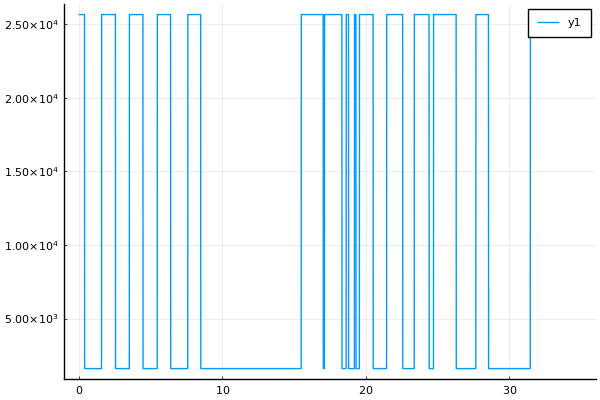

In [198]:
# @gif for i = 1:5:length(sysfinal)
i=100
    Htmp = sys_to_Harray(sysfinal[i])
#         set_linesource_strength!(sys,qtmp)
    plot(sysfinal[i].wall.Xarray,Htmp)
# end

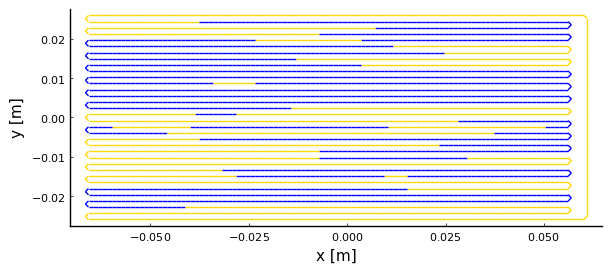

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
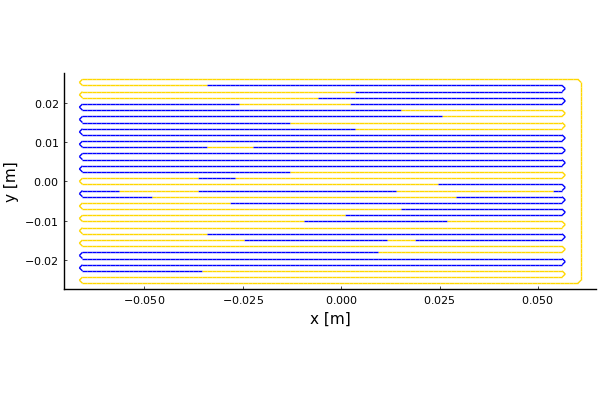

In [206]:
@gif for i=1:5
    Htmp = sys_to_Harray(sysfinal[i])
    plot(ohp,fillalpha=0,linecolor=cgrad([:gold, :blue],rev=true),line_z=Htmp,xlabel="x [m]",ylabel="y [m]")
end

In [676]:
integrator_plate.t

0.10010000000000184

In [208]:
save("plate_OHP.jld2", "plate_hist", plate_hist,"sysfinal", sysfinal)

In [683]:
save("/tmp/myfile.jld", "plate_hist", plate_hist)

In [656]:
z = load("/tmp/myfile.jld", "arr")
tt = load("/tmp/myfile.jld", "t")

15

# temperature difference with OHP

### use the same definition of heat conductance in the ASET paper (temperature based on certain locations)

In [191]:
temp_evaporator = temperature(plate_hist[end])[110,48]

temp_condenser_1 = temperature(plate_hist[end])[44,48]
temp_condenser_2 = temperature(plate_hist[end])[end-44+1,48]
temp_condenser  = (temp_condenser_1+temp_condenser_2)/2

tempdiff_ASET = (temp_evaporator - temp_condenser) # K

0.015067946014284891

### use the same definition of heat conductance based on maximum and minimum temperatures)

In [192]:
tempdiff_maximum = maximum(temperature(plate_hist[end]))-minimum(temperature(plate_hist[end])) # K

0.41379601125174004

# thermal conductance with OHP

### use the same definition of heat conductance in the ASET paper (temperature based on certain locations)

In [193]:
heater_power = 40 #watt
cond_ASET =  heater_power /tempdiff_ASET # W/K

2654.6418444875453

### use the same definition of heat conductance based on maximum and minimum temperatures)

In [194]:
heater_power = 40 #watt
cond_maximum =  heater_power /tempdiff_maximum # W/K

96.66598737624201